In [35]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt


# Loading the dataset

In [36]:
%%time
dir = Path('/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset')

filepaths = list(dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: user 136 ms, sys: 93.7 ms, total: 230 ms
Wall time: 5.25 s


,Filepath,Label
0,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
1,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
2,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
3,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
4,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
...,...,...
6934,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
6935,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
6936,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
6937,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid


In [37]:
dataframe['Label'].value_counts()

pneumonia    2313
normal       2313
covid        2313
Name: Label, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(
 dataframe, test_size=0.13, random_state=0, stratify=dataframe['Label'])
train['Label'].value_counts()

pneumonia    2012
normal       2012
covid        2012
Name: Label, dtype: int64

In [39]:
test['Label'].value_counts()

covid        301
normal       301
pneumonia    301
Name: Label, dtype: int64

# Preprocessing with ImageDataGenerators

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

In [42]:
size=224
color_mode='rgb'
batch_size=32
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)


val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 31 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 4804 validated image filenames belonging to 3 classes.
Found 1201 validated image filenames belonging to 3 classes.
Found 897 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [43]:
test_images.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

# Modeling

In [44]:
from keras.layers import Layer, Conv2D, GlobalAveragePooling2D, Reshape, Multiply, Add, Activation
from keras import backend as K

def config_afr(input_shape, reduction_ratio=16):
    num_channels = input_shape[-1]
    num_reduced_filters = max(num_channels // reduction_ratio, 1)
    return num_channels, num_reduced_filters



class AFR(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(AFR, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.num_channels, self.num_reduced_filters = config_afr(input_shape, self.reduction_ratio)
        self.fc1 = Conv2D(self.num_reduced_filters, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.relu1 = Activation('relu')
        self.fc2 = Conv2D(self.num_channels, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.sigmoid = Activation('sigmoid')
        super(AFR, self).build(input_shape)

    def call(self, inputs):
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, 1, self.num_channels))(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = Multiply()([inputs, x])
        x = Add()([inputs, x])
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(AFR, self).get_config()
        config['reduction_ratio'] = self.reduction_ratio
        return config


In [45]:
from keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model

pre_trained_model = VGG19(input_shape=(size,size,3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False 
    
inputs = Input(shape=(size, size, 3))
x1 =pre_trained_model(inputs)

x4 = AFR(reduction_ratio=8)(x1)

x=Flatten()(x4)
x=Dense(512, activation='relu')(x)
x=Dense(128, activation='relu')(x)
x=Dense(3 , activation='softmax')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
afr_3 (AFR)                  (None, 7, 7, 512)         66112     
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387 

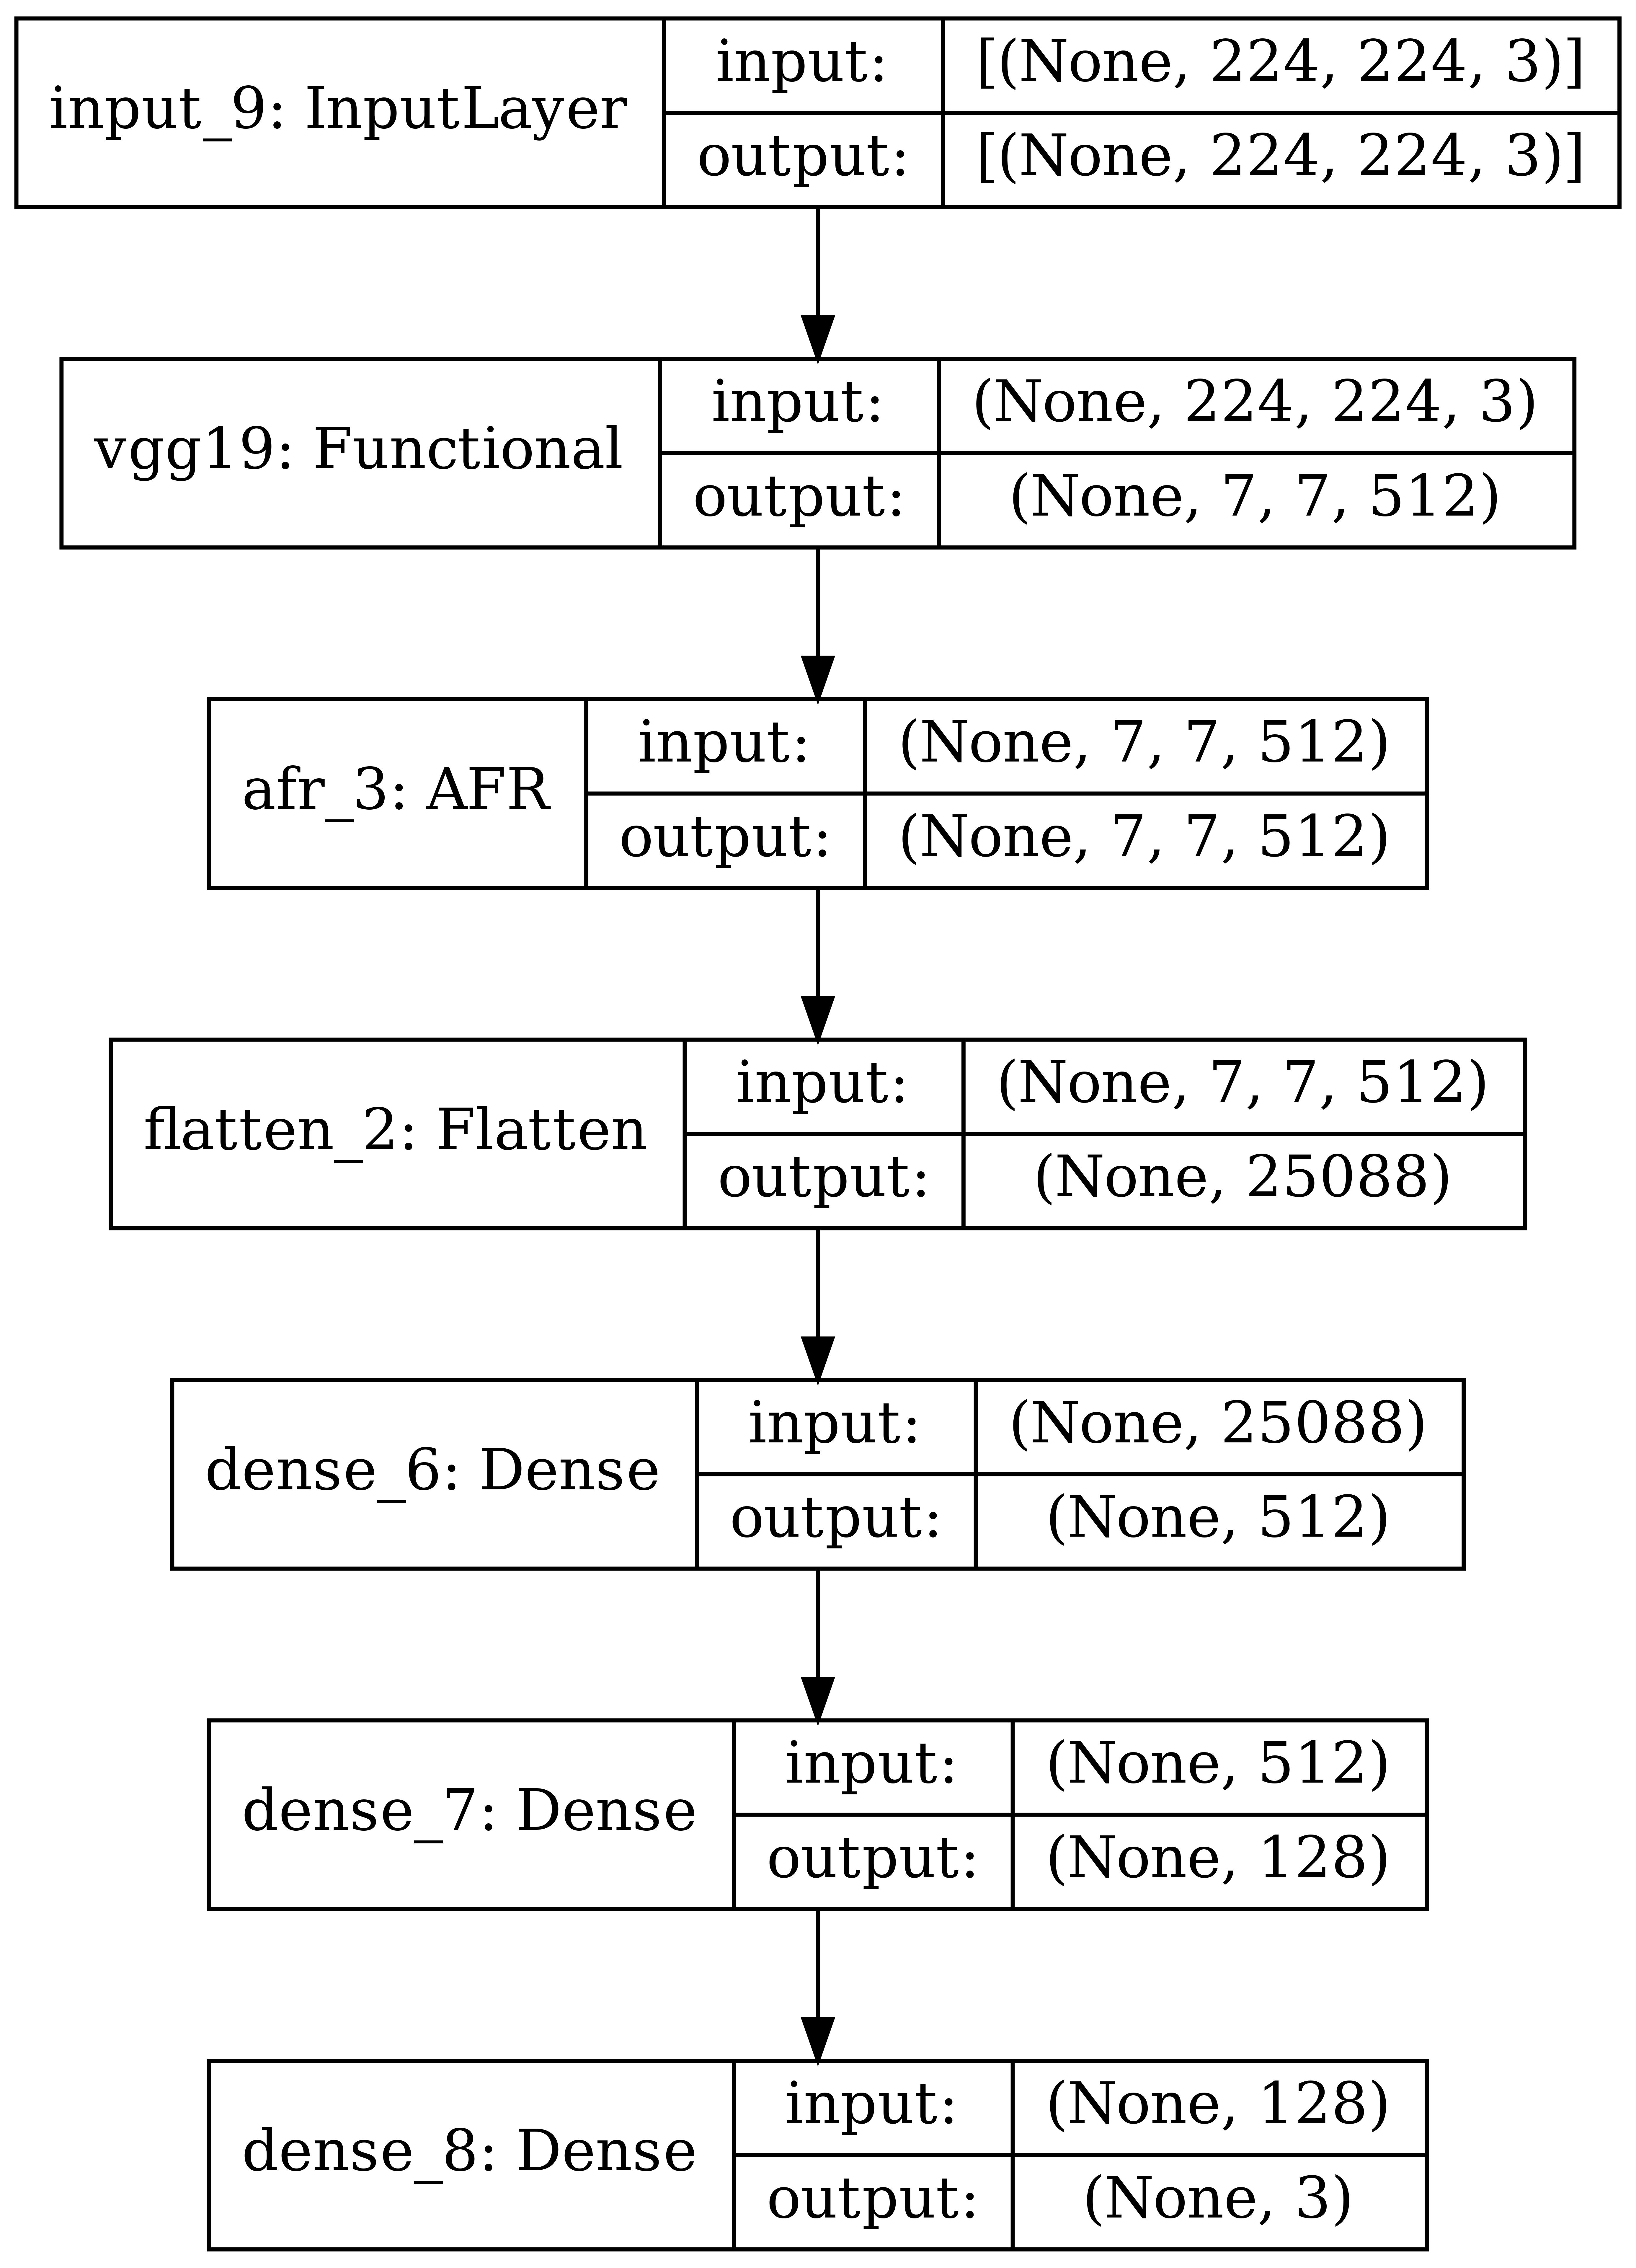

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.jpg",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=1000
)

In [47]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [48]:
from tensorflow.keras.metrics import AUC 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',
             'Precision',
             'Recall',
                    AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
        ]
)

# Model fitting

In [50]:
%%time
result=model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[checkpoint]
)

Epoch 1/30
151/151 [==============================] - 94s 616ms/step - loss: 0.7532 - accuracy: 0.8472 - precision: 0.8560 - recall: 0.8403 - auc_1: 0.9407 - val_loss: 0.3062 - val_accuracy: 0.9126 - val_precision: 0.9160 - val_recall: 0.9084 - val_auc_1: 0.9727

Epoch 00001: val_accuracy improved from -inf to 0.91257, saving model to best_model.h5
Epoch 2/30
151/151 [==============================] - 93s 614ms/step - loss: 0.2366 - accuracy: 0.9207 - precision: 0.9249 - recall: 0.9176 - auc_1: 0.9839 - val_loss: 0.2259 - val_accuracy: 0.9317 - val_precision: 0.9348 - val_recall: 0.9309 - val_auc_1: 0.9838

Epoch 00002: val_accuracy improved from 0.91257 to 0.93172, saving model to best_model.h5
Epoch 3/30
151/151 [==============================] - 92s 608ms/step - loss: 0.1553 - accuracy: 0.9440 - precision: 0.9468 - recall: 0.9413 - auc_1: 0.9920 - val_loss: 0.2103 - val_accuracy: 0.9267 - val_precision: 0.9309 - val_recall: 0.9201 - val_auc_1: 0.9864

Epoch 00003: val_accuracy did n

# Model performance 

In [51]:
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import cohen_kappa_score, f1_score
from keras.models import load_model

best_model=load_model('/kaggle/working/best_model.h5', custom_objects={'AFR': AFR})
results = best_model.evaluate(test_images, verbose=0)
y_pred = best_model.predict(test_images)
y_pred=np.argmax(y_pred, axis=1)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Precision: {:.2f}%".format(results[2] * 100))
print("   Test Recall: {:.2f}%".format(results[3] * 100))
print(" Test f1-score: {:.2f}%".format(f1_score(test_images.labels, y_pred, average='micro') * 100))
print("      Test AUC: {:.4f}".format(results[4] ))
print("         Gmean: {:.2f}%".format(geometric_mean_score(test_images.labels, y_pred)*100) )
print("         kappa: {:.2f}%".format(cohen_kappa_score(test_images.labels, y_pred)*100) )

     Test Loss: 0.2797
 Test Accuracy: 96.10%
Test Precision: 96.10%
   Test Recall: 96.10%
 Test f1-score: 96.10%
      Test AUC: 0.9836
         Gmean: 96.07%
         kappa: 94.15%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)
print('classification report')

report = classification_report(test_images.labels, y_pred, target_names=['covid', 'normal', 'pneumonia'], digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)

[[286   9   0]
 [  1 297   3]
 [  2  20 279]]
classification report
              precision    recall  f1-score   support

       covid     0.9896    0.9695    0.9795       295
      normal     0.9110    0.9867    0.9474       301
   pneumonia     0.9894    0.9269    0.9571       301

    accuracy                         0.9610       897
   macro avg     0.9633    0.9610    0.9613       897
weighted avg     0.9632    0.9610    0.9612       897



# Visualization of training and validation curves 

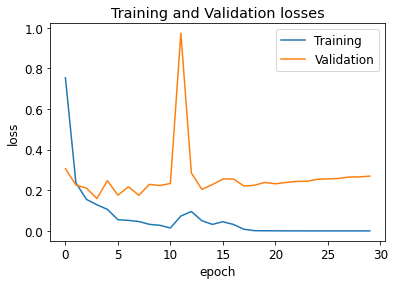

In [52]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

In [1]:
plt.figure(figsize=(20,10))
r=2
c=3

plt.subplot(r,c,1)
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy');

plt.subplot(r,c,2)
plt.plot(result.history['recall'])
plt.plot(result.history['val_recall'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.ylabel('Recall');

plt.subplot(r,c,3)
plt.plot(result.history['precision'])
plt.plot(result.history['val_precision'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.ylabel('Precision');

plt.subplot(r,c,4)
plt.plot(result.history['auc'])
plt.plot(result.history['val_auc'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')
plt.ylabel(' AUC')

plt.subplot(r,c,5)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('Dice loss')
plt.subplots_adjust(hspace=0.3)

plt.subplot(r,c,6)
x = ['Acc', 'Precision', 'Recall','F1-score' ,'AUC']
y = [results[1],results[2] ,results[3],f1_score(test_images.labels, y_pred, average='micro'),results[4]]
plt.bar(x, y, color='red')
plt.xlabel('Measure')
plt.ylabel('Value')
plt.title('Test Measures')

plt.rcParams['font.size'] = '10'

plt.savefig( 'curves.jpg', dpi=1000, bbox_inches = 'tight')

# confusion matrix visualization

Confusion matrix, without normalization


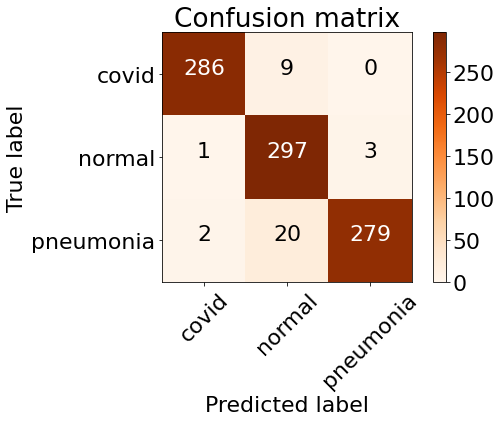

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '12'
    
    
plot_confusion_matrix(cm, classes=['covid', 'normal', 'pneumonia'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

Normalized confusion matrix


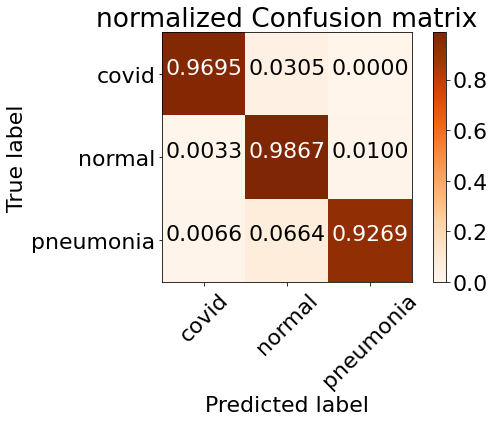

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '24'  
    
    
plot_confusion_matrix(cm, classes=['covid', 'normal', 'pneumonia'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

#  Predictions on a new image

In [3]:
import cv2
from AFR import AFR
from keras.models import load_model

img = cv2.imread('test-sample.jpeg')

if len(img.shape) == 3:
        img = cv2.resize(img, (224, 224))
        img = img / 255
        model = load_model("covid_best_model.h5", custom_objects={"AFR": AFR})
        pred1 = model.predict(img.reshape(1, 224, 224, 3), batch_size=1, verbose=0)
        pred = pred1.argmax()

        covid_labels = {0: "COVID-19", 1: "Normal", 2: "Pneumonia"}
        x = (
            covid_labels.get(pred, "Unknown")
            + ", "
            + (pred1[0][pred] * 100).astype("str")[:6]
            + "%"
        )
        print(x)
elif len(img.shape) == 2:
    print('unable to make prediction on this image as it is not RGB')

COVID-19, 99.999%
